<a href="https://colab.research.google.com/github/s1m0nS/mapAI-UNet/blob/main/UNet_binary_segmentation_mapAI_small-working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Binary semantic segmentation example using U-Net

https://github.com/bnsreenu/python_for_image_processing_APEER/blob/master/tutorial118_binary_semantic_segmentation_using_unet.ipynb

In [1]:
# Libraries

# Change runtime type in Colab

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # ignore tensorflow warnings
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' # allow GPU memory growth

import glob

import cv2
from PIL import Image

import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.utils import normalize
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam

In [2]:
import tensorflow as tf
print(tf.test.gpu_device_name())
print('\n')

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/device:GPU:0


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9282934496042876351
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14417788928
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16821389325407109416
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
# Unzip dataset --> run only in Colab
import zipfile

# '/content/drive/MyDrive/mapAI_small/mapai_small.zip'

mapai_zip = '/content/drive/MyDrive/mapAI_small/mapai_small.zip'
zip_ref = zipfile.ZipFile(mapai_zip, 'r')
zip_ref.extractall("/tmp") # extracting dataset to tmp folder
zip_ref.close()

# Re-run from here after first run! 

In [7]:
# Configure paths

img_dir = '/tmp/mapai_small/train/images'
mask_dir = '/tmp/mapai_small/train/masks'

In [8]:
SIZE = 500
num_images = 510

#### Load images and masks in order so they match.

#### IMAGES

In [9]:
image_names = glob.glob('/tmp/mapai_small/train/images/*.png')

# Create subset
image_names_subset = image_names[0:num_images]
# Read each subset with cv2
images = [cv2.imread(img, 0) for img in image_names_subset]
# Create dataset
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

print(len(image_dataset))

510


#### MASKS

In [12]:
mask_names = glob.glob('/tmp/mapai_small/train/masks/*.png')
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

print(len(mask_dataset))

510


#### Print properties of images

In [13]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (510, 500, 500, 1)
Mask data shape is:  (510, 500, 500, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


#### Normalize images
Getting OOM errors, maybe need to find a better way to normalize images.

In [14]:
# IMAGES
# Solution: https://stackoverflow.com/questions/62977311/how-can-i-stop-my-colab-notebook-from-crashing-while-normalising-my-images

# float16 or float32? Find answer

image_dataset = (image_dataset / 255.0).astype(np.float16)  #Can also normalize or scale using MinMax scaler

In [15]:
# Need to figure out a way to lower system RAM after normalization
# works in Colab with small datasets

numpy.ndarray

In [16]:
# MASKS

#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = (mask_dataset / 255.0).astype(np.float16)   #PIxel values will be 0 or 1

In [ ]:
# 
print(len(image_dataset), len(mask_dataset))

#### Perform train/test split

In [17]:
# Train/test split 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

#### Randomly view some images from train and test sample

In [21]:
# needs a solution

### Resize images to approptiate shape for UNet

In [34]:
def resize(image, mask):
    input_image = tf.image.resize(image, (480, 480), method='bicubic')
    input_mask = tf.image.resize(mask, (480, 480), method='bicubic')
    return input_image, input_mask

X_train, y_train = resize(X_train, y_train)
X_test, y_test = resize(X_test, y_test)

### U-Net


In [65]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 60)
    s2, p2 = encoder_block(p1, 120)
    s3, p3 = encoder_block(p2, 240)
    s4, p4 = encoder_block(p3, 480)

    b1 = conv_block(p4, 960) #Bridge

    d1 = decoder_block(b1, s4, 480)
    d2 = decoder_block(d1, s3, 240)
    d3 = decoder_block(d2, s2, 120)
    d4 = decoder_block(d3, s1, 60)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [44]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(480, 480, 1)


In [66]:
# Build the model
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 480, 480, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_43 (Conv2D)             (None, 480, 480, 60  600         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_42 (BatchN  (None, 480, 480, 60  240        ['conv2d_43[0][0]']              
 ormalization)                  )                                                     

### Train model or at least try
https://www.youtube.com/watch?v=7j0yL8A-k4E

In [67]:
history = model.fit(X_train, y_train, 
                    batch_size = 4, 
                    verbose=1, 
                    epochs= 5, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

# System RAM: 6.9/12.7
# GPU RAM: 14.3/15

Epoch 1/5
128/128 [==============================] - 127s 956ms/step - loss: 0.4085 - accuracy: 0.8375 - val_loss: 1.7069 - val_accuracy: 0.8526
Epoch 2/5
128/128 [==============================] - 119s 933ms/step - loss: 0.3808 - accuracy: 0.8537 - val_loss: 0.4740 - val_accuracy: 0.8526
Epoch 3/5
128/128 [==============================] - 119s 931ms/step - loss: 0.3825 - accuracy: 0.8541 - val_loss: 0.3967 - val_accuracy: 0.8526
Epoch 4/5
128/128 [==============================] - 119s 928ms/step - loss: 0.3816 - accuracy: 0.8540 - val_loss: 0.4030 - val_accuracy: 0.8526
Epoch 5/5
128/128 [==============================] - 119s 927ms/step - loss: 0.3935 - accuracy: 0.8541 - val_loss: 0.3999 - val_accuracy: 0.8526


In [ ]:
'''
Epoch 1/5
128/128 [==============================] - 154s 1s/step - loss: 0.4081 - accuracy: 0.8392 - val_loss: 1.9037 - val_accuracy: 0.7150
Epoch 2/5
128/128 [==============================] - 121s 945ms/step - loss: 0.3706 - accuracy: 0.8539 - val_loss: 0.4112 - val_accuracy: 0.8526
Epoch 3/5
128/128 [==============================] - 121s 943ms/step - loss: 0.3821 - accuracy: 0.8533 - val_loss: 0.4009 - val_accuracy: 0.8512
Epoch 4/5
128/128 [==============================] - 120s 942ms/step - loss: 0.3910 - accuracy: 0.8535 - val_loss: 0.4280 - val_accuracy: 0.8526
Epoch 5/5
128/128 [==============================] - 121s 943ms/step - loss: 0.3779 - accuracy: 0.8540 - val_loss: 0.7315 - val_accuracy: 0.6046
'''

In [73]:
#Save the model for future use
model.save('/content/drive/MyDrive/models/mapAI_small_5-epochs.hdf5')

### Plot training and validation accuracy

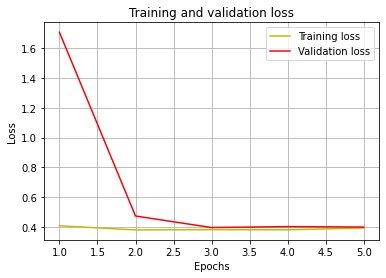

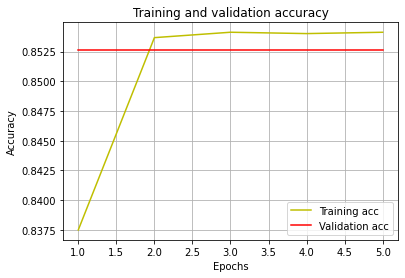

In [74]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Load previously saved model

In [75]:
#Load previously saved model
from keras.models import load_model

model_path = '/content/drive/MyDrive/models/mapAI_small_5-epochs.hdf5'

model = load_model(model_path, compile=False)

### Prediction

In [71]:
# IOU threshold
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

4/4 [==============================] - 9s 2s/step


In [76]:
from tensorflow.keras.metrics import MeanIoU

# binary classification --> 2 classes
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.4290469


(1, 480, 480, 1)
1/1 [==============================] - 0s 20ms/step
(480, 480)


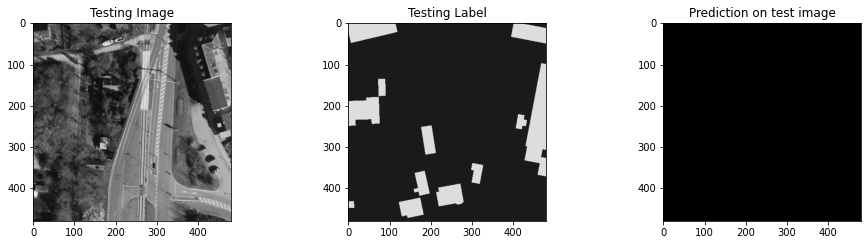

In [85]:
threshold = 0.5

import random

test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

#### Problems




*   Test images and labels are different? Why?
*   Possible issue at dataset split?
*   Check if the mapAI_small dataset was correctly copied.

## To solve:
*   Plot real color images not gray
*   other?

Why: https://www.youtube.com/watch?v=coY2IA-oBvw



